In [2]:
import json, glob, os, sys
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sys.path.append(CODE) # set sys.path in order to load modules
from calc_util import sliding_maxnorm_ht
from adaint import integrate, default_steps_per_time, integrate2
import system #,container, setup
from scipy.integrate import odeint

In [92]:
# figure settings
h, w = 6, 9
lw = 2
colors = ['#002138', '#3C78A8', '#8BBEDE', 
          '#002138', '#3F7234', '#A4BA35', #'#86AD10' '#0A5100''#5F8731'
         ]
import seaborn as sns
sns.set_theme(style='white')
sns.set_context('paper')

In [3]:
def f(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)

    return(dI1, dM1, dR1, dI2, dM2, dR2)

In [4]:
# set parameters
 
p0=[0.023, 34.44, 17.7071, 0.038241, 57.9236, 1.39117, 0.000534, 
            0.016011, 14.3342,  4.33609, 0.001471, 26.1702, 45.9986, 0.79082] #only rates and ODE parameters
Ton= 1.1111111111111112
Amin=0

X0 = [0,0,0,0,0,0] 

steps_per_time = 100

labels=[r"$I_1$", r"$M_1$", r"$R_1$", r"$I_2$", r"$M_2$", r"$R_2$"] #should match order in X0

mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0)


# F-sensitivity

In [121]:
# generate data
S=10
T_scan_set = [15, 20, 25]
traj = []
tvecs = []
ht = []
rt=[]
recovery_traj = []
for j, T in enumerate(T_scan_set): 
    ht_,rt_ = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01, recovery_threshold=0.95)
    ht.append(ht_)
    rt.append(rt_)
    traj.append(mys.computational_data["trajectory"])
    tvecs.append(mys.computational_data["tvec"])
    recovery_traj.append(mys.computational_data["recovery_trajectory"])

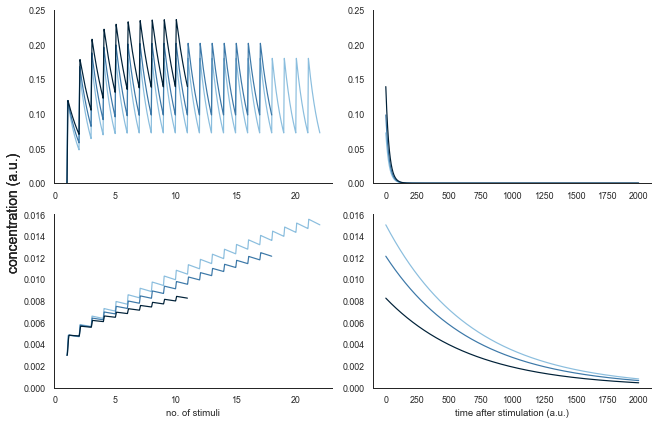

In [128]:
# plot memory build-up and decay
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(w, h))

for i in range(0,3):
    # M1
    ax = axes[0][0]
    y = traj[2-i][:ht[2-i]*T_scan_set[2-i]*steps_per_time,1]
    x = tvecs[2-i][:ht[2-i]*T_scan_set[2-i]*steps_per_time]/T_scan_set[2-i]+1 # no of stimuli
    ax.plot(x, y, color = colors[2-i])
    ax.set_ylim(0,0.25)
    
    # M2
    ax = axes[1][0]
    y = traj[2-i][:ht[2-i]*T_scan_set[2-i]*steps_per_time,4]
    x = tvecs[2-i][:ht[2-i]*T_scan_set[2-i]*steps_per_time]/T_scan_set[2-i]+1 # no of stimuli
    ax.plot(x, y, color = colors[2-i])
    ax.set_ylim(0,0.016)
    ax.set_xlabel('no. of stimuli')
    
    # M1 recovery
    ax = axes[0][1]
    y = recovery_traj[2-i][:200000,1]
    x = np.arange(0,len(y))/steps_per_time
    ax.plot(x, y, color = colors[2-i])
    ax.set_ylim(0,0.25)
    
    # M2 recovery
    ax = axes[1][1]
    y = recovery_traj[2-i][:200000,4]
    x = np.arange(0,len(y))/steps_per_time
    ax.plot(x, y, color = colors[2-i])
    ax.set_ylim(0,0.016)
    ax.set_xlabel('time after stimulation (a.u.)')
    
    
    fig.text(-0.01, 0.5, 'concentration (a.u.)', va='center', rotation='vertical', fontsize=14)
    
    sns.despine()
    plt.tight_layout()
    plt.savefig('IFF_concat_fsens_memory_levels.pdf')
    

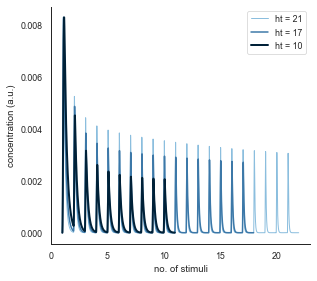

In [124]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(w/2, h/1.5))

for i in range(0,3):
    # M1
    ax = axes
    y = traj[2-i][:ht[2-i]*T_scan_set[2-i]*steps_per_time,-1]
    x = tvecs[2-i][:(ht[2-i])*T_scan_set[2-i]*steps_per_time]/T_scan_set[2-i]+1 # no of stimuli
    ax.plot(x, y,
            color = colors[2-i], lw=1+0.5*i,
            label='ht = '+str(ht[2-i]))
    ax.set_xlabel('no. of stimuli')
    ax.set_ylabel('concentration (a.u.)')

plt.legend()
sns.despine()
plt.tight_layout() 
plt.savefig('IFF_concat_fsens.pdf')

# Intensity sensitivity 

In [130]:
# generate data
T=15
Amax_scan_set = [10, 20, 30]
traj = []
tvecs = []
ht = []
rt=[]
#recovery_traj = []
for Amax in Amax_scan_set: 
    ht_,rt_ = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=0.01, recovery_threshold=0.95)
    ht.append(ht_)
    rt.append(rt_)
    traj.append(mys.computational_data["trajectory"])
    tvecs.append(mys.computational_data["tvec"])
    #recovery_traj.append(mys.computational_data["recovery_trajectory"])

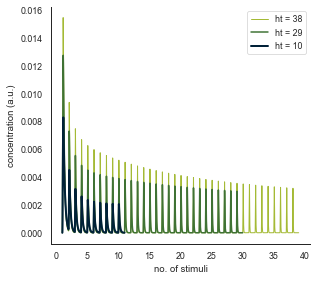

In [131]:
# plot I-sensitivity
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(w/2, h/1.5))

for i in range(0,3):
    ax = axes
    y = traj[2-i][:ht[2-i]*T*steps_per_time,-1]
    x = tvecs[2-i][:ht[2-i]*T*steps_per_time]/T+1 # no of stimuli
    ax.plot(x, y,
            color = colors[5-i], lw=1+0.5*i,
            label='ht = '+str(ht[2-i]))
    ax.set_xlabel('no. of stimuli')
    ax.set_ylabel('concentration (a.u.)')

plt.legend()
sns.despine()
plt.tight_layout() 
plt.savefig('IFF_concat_Isens.pdf')

# Potentiation of habituation 

In [133]:
# generate data
T=20
Amax = 10
rt_fraction = 0.5
X0 = [0,0,0,0,0,0] #initial steady-state

# first train of stimuli
mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)
ht,rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01,recovery_threshold=0.95)
traj = mys.computational_data["trajectory"][:ht*T*steps_per_time]
peak = mys.computational_data['peaks_level'][ht]

# recovery trajectory
recovery_traj = mys.computational_data['recovery_trajectory'][:int(rt_fraction*int(rt))*steps_per_time,:]

# second train of stimuli
X1 = recovery_traj[-1] # extract new initial condition
X1[X1 < 0] = 0 # prevent negative blowup
mys = system.System(f,p0, X1,output_var_idx=-1,steps_per_time=100,hmax=0)
ht2,rt2 = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01,recovery_threshold=0.95)
traj2 = mys.computational_data["trajectory"][:ht2*T*steps_per_time]
peak2 = mys.computational_data['peaks_level'][ht2]

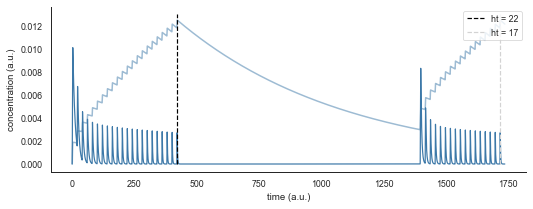

In [152]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(w/1.2, h/2))
ax = axes
y = np.concatenate([np.array(traj), np.array(recovery_traj), np.array(traj2)])
x = np.arange(0,len(y))/steps_per_time

ax.plot(x,y[:,-1], color=colors[1]) # R2
ax.plot(x,y[:,-2], color=colors[1], lw=1.5, alpha=0.5) # M2
ax.plot([(ht-1)*T,(ht-1)*T], [0,0.013], 
        '--', color='black', label='ht = '+str(ht))
ax.plot([(ht-1+ht2)*T+int(int(rt)*rt_fraction), (ht-1+ht2)*T+int(int(rt)*rt_fraction)], [0,0.013], 
        '--', color='lightgrey', label='ht = '+str(ht2))

#ax.plot((ht-1)*T, peak, 'o', color='black', label='ht = '+str(ht))
#ax.plot((ht-1+ht2)*T+int(int(rt)*rt_fraction), peak, 'o', color='grey', label='ht = '+str(ht2))
ax.set_xlabel('time (a.u.)')
ax.set_ylabel('concentration (a.u.)')

plt.legend(loc=1)
sns.despine()
plt.tight_layout() 
plt.savefig('IFF_concat_potentiation.pdf')


# Subliminal Accumulation

In [191]:
# generate data
T=15
S=10
mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

# original system
ht,rt=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01,recovery_threshold=0.95)
traj = mys.computational_data['trajectory'][:ht*T*steps_per_time]
recovery = mys.computational_data['recovery_trajectory'][:int(rt*steps_per_time)]
recovered_peak = mys.computational_data['perturbational_trajectory'][round(rt-0.01, 2)].tolist()

# system with more peaks (low ht threshold)
ht2,rt2=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.005,recovery_threshold=0.95)
traj2 = mys.computational_data['trajectory'][:ht2*T*steps_per_time,:]
recovery2 = mys.computational_data['recovery_trajectory'][:int(rt2*steps_per_time),:]
recovered_peak2 = mys.computational_data['perturbational_trajectory'][round(rt2-0.01, 2)].tolist()

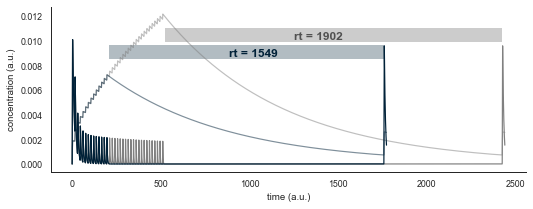

In [190]:
# plot (T=15, S=10)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(w/1.2, h/2))
ax = axes

y = np.concatenate([np.array(traj), np.array(recovery), np.array(recovered_peak)])
x = np.arange(0, len(y))/steps_per_time

y2 = np.concatenate([np.array(traj2), np.array(recovery2), np.array(recovered_peak2)])
x2 = np.arange(0, len(y2))/steps_per_time

ax.plot(x2, y2[:,-2], color='grey', alpha=0.5) #M2'
ax.plot(x2, y2[:,-1], color='grey') #R2'
ax.plot(x, y[:,-2], color=colors[0], alpha=0.5) #M2
ax.plot(x, y[:,-1], color=colors[0]) #R2

ax.set_xlabel('time (a.u.)')
ax.set_ylabel('concentration (a.u.)')

# add rt description
ax.errorbar(ht*T+rt/2, 0.0091, xerr=rt/2,
            color=colors[0],lw=14, alpha=0.3)
ax.errorbar(ht2*T+rt2/2, 0.0105, xerr=rt2/2,
            color='grey',lw=14, alpha=0.4)
fig.text(0.43, 0.72, 'rt = '+str(round(rt)), fontsize=12, 
         color=colors[0], weight='bold')
fig.text(0.55, 0.8, 'rt = '+str(round(rt2)), fontsize=12, 
         color='black', alpha=0.6, weight='bold')


sns.despine()
plt.tight_layout() 
plt.savefig('IFF_concat_subliminal_accumulation.pdf')


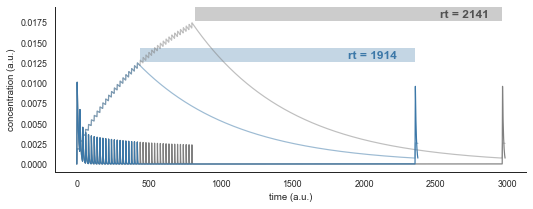

In [202]:
# plot (T=20, S=10)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(w/1.2, h/2))
ax = axes

y = np.concatenate([np.array(traj), np.array(recovery), np.array(recovered_peak)])
x = np.arange(0, len(y))/steps_per_time

y2 = np.concatenate([np.array(traj2), np.array(recovery2), np.array(recovered_peak2)])
x2 = np.arange(0, len(y2))/steps_per_time

ax.plot(x2, y2[:,-2], color='grey', alpha=0.5) #M2'
ax.plot(x2, y2[:,-1], color='grey') #R2'
ax.plot(x, y[:,-2], color=colors[1], alpha=0.5) #M2
ax.plot(x, y[:,-1], color=colors[1]) #R2

ax.set_xlabel('time (a.u.)')
ax.set_ylabel('concentration (a.u.)')

# add rt description
ax.errorbar(ht*T+rt/2, 0.0135, xerr=rt/2,
            color=colors[1],lw=14, alpha=0.3)
ax.errorbar(ht2*T+rt2/2, 0.0185, xerr=rt2/2,
            color='grey',lw=14, alpha=0.4)
fig.text(0.65, 0.71, 'rt = '+str(round(rt)), fontsize=12, 
         color=colors[1], weight='bold')
fig.text(0.82, 0.9, 'rt = '+str(round(rt2)), fontsize=12, 
         color='black', alpha=0.6, weight='bold')


sns.despine()
plt.tight_layout() 
plt.savefig('IFF_concat_subliminal_accumulation_2.pdf')

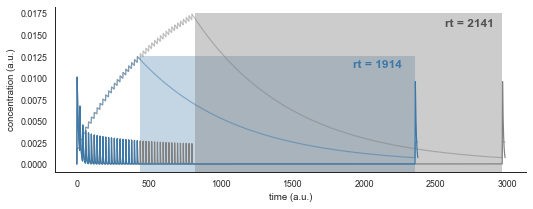

In [222]:
# plot (T=20, S=10)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(w/1.2, h/2))
ax = axes

y = np.concatenate([np.array(traj), np.array(recovery), np.array(recovered_peak)])
x = np.arange(0, len(y))/steps_per_time

y2 = np.concatenate([np.array(traj2), np.array(recovery2), np.array(recovered_peak2)])
x2 = np.arange(0, len(y2))/steps_per_time

ax.plot(x2, y2[:,-2], color='grey', alpha=0.5) #M2'
ax.plot(x2, y2[:,-1], color='grey') #R2'
ax.plot(x, y[:,-2], color=colors[1], alpha=0.5) #M2
ax.plot(x, y[:,-1], color=colors[1]) #R2

ax.set_xlabel('time (a.u.)')
ax.set_ylabel('concentration (a.u.)')

# add rt description
ax.errorbar(ht*T+rt/2, 0.004, xerr=rt/2,
            color=colors[1],lw=148, alpha=0.3)
ax.errorbar(ht2*T+rt2/2, 0.008, xerr=rt2/2,
            color='grey',lw=164, alpha=0.4)
fig.text(0.66, 0.67, 'rt = '+str(round(rt)), fontsize=12, 
         color=colors[1], weight='bold')
fig.text(0.83, 0.86, 'rt = '+str(round(rt2)), fontsize=12, 
         color='black', alpha=0.6, weight='bold')


sns.despine()
plt.tight_layout() 
plt.savefig('IFF_concat_subliminal_accumulation_3.pdf')

# all trajectories

In [ ]:
# generate data
S=10
T_scan_set = [15, 20, 25]
traj = []
tvecs = []
ht = []
rt=[]
recovery_traj = []
for j, T in enumerate(T_scan_set): 
    ht_,rt_ = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01, recovery_threshold=0.95)
    ht.append(ht_)
    rt.append(rt_)
    traj.append(mys.computational_data["trajectory"])
    tvecs.append(mys.computational_data["tvec"])
    recovery_traj.append(mys.computational_data["recovery_trajectory"])

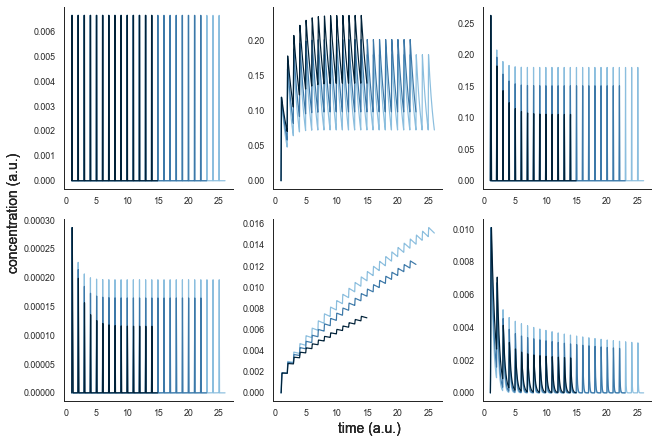

In [232]:
# plot all trajectories
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(w, h))

for i in range(0,3):
    for k in range(0,6):
        ax = axes[k//3][k%3]
        y = traj[2-i][:ht[2-i]*T_scan_set[2-i]*steps_per_time,k]
        x = tvecs[2-i][:ht[2-i]*T_scan_set[2-i]*steps_per_time]/T_scan_set[2-i]+1 # no of stimuli
        ax.plot(x, y, color = colors[2-i])

    
    fig.text(-0.01, 0.5, 'concentration (a.u.)', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0, 'time (a.u.)', va='center', fontsize=14)
    
    sns.despine()
    plt.tight_layout()
    plt.savefig('IFF_concat_alltrajectories.pdf')